<a href="https://colab.research.google.com/github/ayyucedemirbas/ExonJunctionAnalyzer/blob/main/exon_junction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric

In [ ]:
!pip install pysam

In [ ]:
!wget -N https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_45/gencode.v45.annotation.gtf.gz
!gunzip -f gencode.v45.annotation.gtf.gz

Reads Processed: 0 read [00:00, ? read/s]

Found 8449 unique splice junctions.
Analyzing LSVs (Min Reads=10, Min PSI=0.1)...
Identified 1949 significant LSVs.
Normal Tissue Top Visualizations


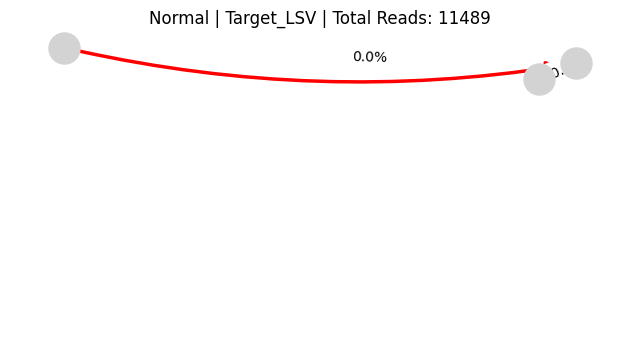

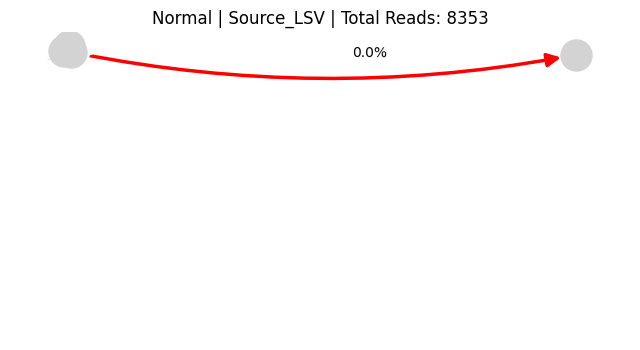

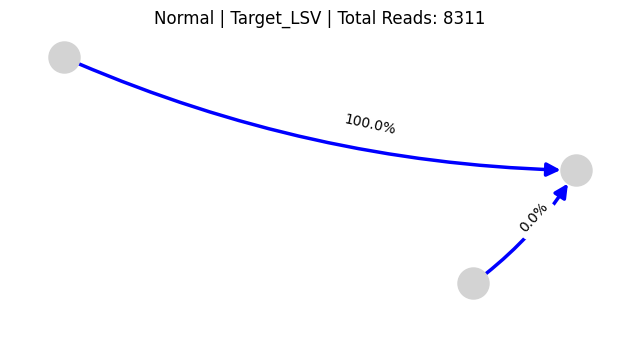

Reads Processed: 0 read [00:00, ? read/s]

Found 38141 unique splice junctions.
Analyzing LSVs (Min Reads=10, Min PSI=0.1)...
Identified 6722 significant LSVs.
Cancer Tissue Top Visualizations:


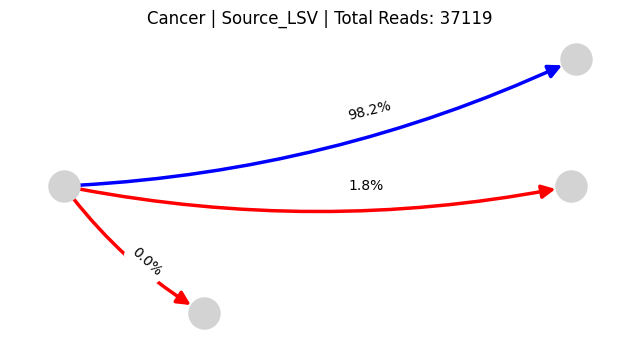

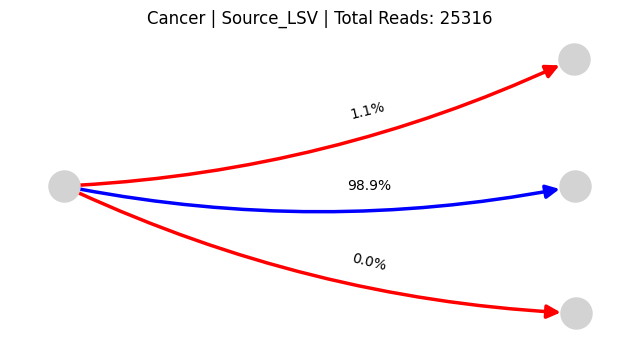

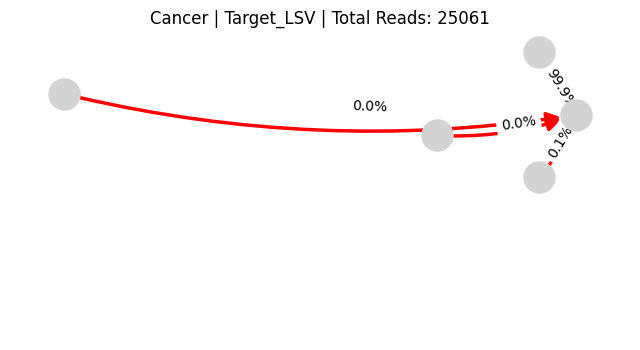

In [5]:
import pysam
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import sys
import os
from tqdm.notebook import tqdm

class SpliceGraphAnalyzer:
    def __init__(self, bam_file, gtf_file, output_prefix):
        self.bam_file = bam_file
        self.gtf_file = gtf_file
        self.output_prefix = output_prefix

        self.junctions = Counter()
        self.known_introns = defaultdict(set)
        self.graph = nx.DiGraph()
        self.chrom_map = {}

    def load_annotation(self):
        count = 0
        try:
            with open(self.gtf_file, 'r') as f:
                for line in f:
                    if line.startswith('#'): continue
                    parts = line.strip().split('\t')
                    if len(parts) < 9: continue

                    feature_type = parts[2]
                    chrom = parts[0]

                    if not chrom.startswith('chr'):
                        chrom = 'chr' + chrom

                    if chrom not in self.chrom_map:
                        self.chrom_map[chrom] = len(self.chrom_map)

                    if feature_type == 'exon':
                        start = int(parts[3])
                        end = int(parts[4])
                        self.known_introns[chrom].add(start - 1)
                        self.known_introns[chrom].add(end)
                        count += 1


        except Exception as e:
            print(f"Error reading annotation file: {e}")

    def process_bam(self):
        try:
            samfile = pysam.AlignmentFile(self.bam_file, "rb", check_sq=False)

            for read in tqdm(samfile, desc="Reads Processed", unit=" read"):
                if read.is_unmapped or read.is_secondary or read.is_duplicate:
                    continue

                if not read.cigarstring or 'N' not in read.cigarstring:
                    continue

                chrom = read.reference_name
                if not chrom: continue
                if not chrom.startswith('chr'): chrom = 'chr' + chrom

                if chrom not in self.chrom_map:
                     self.chrom_map[chrom] = len(self.chrom_map)

                current_pos = read.reference_start

                if read.cigartuples:
                    for op, length in read.cigartuples:
                        if op in [0, 2, 7, 8]:
                            current_pos += length
                        elif op == 3:
                            j_start = current_pos
                            j_end = current_pos + length
                            self.junctions[(chrom, j_start, j_end)] += 1
                            current_pos += length

            samfile.close()
            print(f"Found {len(self.junctions)} unique splice junctions.")

        except Exception as e:
            print(f"Error reading BAM file: {e}")

    def build_graph(self):
        for (chrom, start, end), count in self.junctions.items():
            u = f"{chrom}:{start}"
            v = f"{chrom}:{end}"

            self.graph.add_edge(u, v, weight=count)
            is_known = self._check_is_known(chrom, start, end)

            self.graph[u][v].update({
                'type': 'known' if is_known else 'novel',
                'chrom': chrom,
                'start': start,
                'end': end
            })

    def _check_is_known(self, chrom, j_start, j_end):
        if chrom not in self.known_introns:
            return False
        return (j_start in self.known_introns[chrom]) and (j_end in self.known_introns[chrom])

    def find_lsvs(self, min_reads=5, min_psi=0.10):
        print(f"Analyzing LSVs (Min Reads={min_reads}, Min PSI={min_psi})...")
        lsvs = []

        for node in self.graph.nodes():
            out_edges = list(self.graph.out_edges(node, data=True))
            in_edges = list(self.graph.in_edges(node, data=True))

            if len(out_edges) > 1:
                total_reads = sum([d['weight'] for u, v, d in out_edges])
                if total_reads >= min_reads:
                    lsv_data = {'type': 'Source_LSV', 'ref_node': node, 'total_reads': total_reads, 'edges': []}
                    valid_lsv = False
                    for u, v, d in out_edges:
                        psi = d['weight'] / total_reads
                        if psi >= min_psi: valid_lsv = True
                        lsv_data['edges'].append({'target': v, 'reads': d['weight'], 'psi': psi, 'annotation': d['type'], 'coords': (d['chrom'], d['start'], d['end'])})
                    if valid_lsv: lsvs.append(lsv_data)

            if len(in_edges) > 1:
                total_reads = sum([d['weight'] for u, v, d in in_edges])
                if total_reads >= min_reads:
                    lsv_data = {'type': 'Target_LSV', 'ref_node': node, 'total_reads': total_reads, 'edges': []}
                    valid_lsv = False
                    for u, v, d in in_edges:
                        psi = d['weight'] / total_reads
                        if psi >= min_psi: valid_lsv = True
                        lsv_data['edges'].append({'source': u, 'reads': d['weight'], 'psi': psi, 'annotation': d['type'], 'coords': (d['chrom'], d['start'], d['end'])})
                    if valid_lsv: lsvs.append(lsv_data)

        lsvs.sort(key=lambda x: x['total_reads'], reverse=True)
        print(f"Identified {len(lsvs)} significant LSVs.")
        return lsvs

    def visualize_lsv(self, lsv_data, lsv_id):
        subgraph = nx.DiGraph()
        labels = {}
        colors = []
        pos = {}

        ref_node = lsv_data['ref_node']
        try: ref_pos = int(ref_node.split(':')[1])
        except: ref_pos = 0

        subgraph.add_node(ref_node)
        pos[ref_node] = (ref_pos, 0)

        num_edges = len(lsv_data['edges'])
        y_offsets = [i - (num_edges - 1) / 2 for i in range(num_edges)]
        y_offsets.reverse()

        for i, edge in enumerate(lsv_data['edges']):
            other_node = edge.get('target', edge.get('source'))
            try: other_pos_val = int(other_node.split(':')[1])
            except: other_pos_val = ref_pos + 100

            subgraph.add_node(other_node)
            pos[other_node] = (other_pos_val, y_offsets[i] * 100)

            if lsv_data['type'] == 'Source_LSV':
                subgraph.add_edge(ref_node, other_node)
            else:
                subgraph.add_edge(other_node, ref_node)

            key = (ref_node, other_node) if lsv_data['type'] == 'Source_LSV' else (other_node, ref_node)
            labels[key] = f"{edge['psi']*100:.1f}%"
            colors.append('blue' if edge['annotation'] == 'known' else 'red')

        plt.figure(figsize=(8, 4))
        plt.title(f"{self.output_prefix} | {lsv_data['type']} | Total Reads: {lsv_data['total_reads']}")

        nx.draw(subgraph, pos, with_labels=False, node_color='lightgray',
                edge_color=colors, width=2.5, node_size=500,
                connectionstyle='arc3,rad=0.1', arrowsize=20)

        nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels, font_color='black', label_pos=0.6)

        plt.show()


GTF_FILE = "gencode.v45.annotation.gtf"
NORMAL_BAM = "/content/drive/MyDrive/bam_files/normal_mcf10a_sorted.bam"
CANCER_BAM = "/content/drive/MyDrive/bam_files/cancer_mcf7.bam"


if os.path.exists(NORMAL_BAM):
    analyzer_normal = SpliceGraphAnalyzer(NORMAL_BAM, GTF_FILE, "Normal")
    analyzer_normal.load_annotation()
    analyzer_normal.process_bam()
    analyzer_normal.build_graph()
    results_normal = analyzer_normal.find_lsvs(min_reads=10, min_psi=0.1)

    print("Normal Tissue Top Visualizations")
    for i, lsv in enumerate(results_normal[:3]):
        analyzer_normal.visualize_lsv(lsv, i+1)
else:
    print(f"File {NORMAL_BAM} not found")


if os.path.exists(CANCER_BAM):
    analyzer_cancer = SpliceGraphAnalyzer(CANCER_BAM, GTF_FILE, "Cancer")
    analyzer_cancer.load_annotation()
    analyzer_cancer.process_bam()
    analyzer_cancer.build_graph()
    results_cancer = analyzer_cancer.find_lsvs(min_reads=10, min_psi=0.1)

    print("Cancer Tissue Top Visualizations:")
    for i, lsv in enumerate(results_cancer[:3]):
        analyzer_cancer.visualize_lsv(lsv, i+1)
else:
    print(f"File {CANCER_BAM} not found!")